Loading Data...
Running Backtest (Unhedged Futures)...

--- PERFORMANCE SUMMARY (UNHEDGED) ---
                  Benchmark (EqW)  Fund L/S (Unhedged)
Ann. Return (XS)         0.035121             0.016400
Ann. Volatility          0.146897             0.087741
Sharpe Ratio             0.239086             0.186919
Beta                     1.000000             0.003953
Ann. Alpha               0.000000             0.016262
Correlation              1.000000             0.006619

--- DETAILED MONTHLY RETURNS & WEIGHTS ---
             ret_net  ret_gross    ret_rf    ret_bm      w_AU      w_CH      w_EM      w_EU      w_GB      w_JP      w_US
Date                                                                                                                     
1999-10-31 -0.001770  -0.001604  0.004267  0.033455  0.000000  0.000000  0.000000  0.000000  0.500000 -0.225890 -0.274110
1999-11-30 -0.001256  -0.001121  0.004417  0.022158  0.000000  0.000000  0.000000  0.000000  0.500000 -0.17436

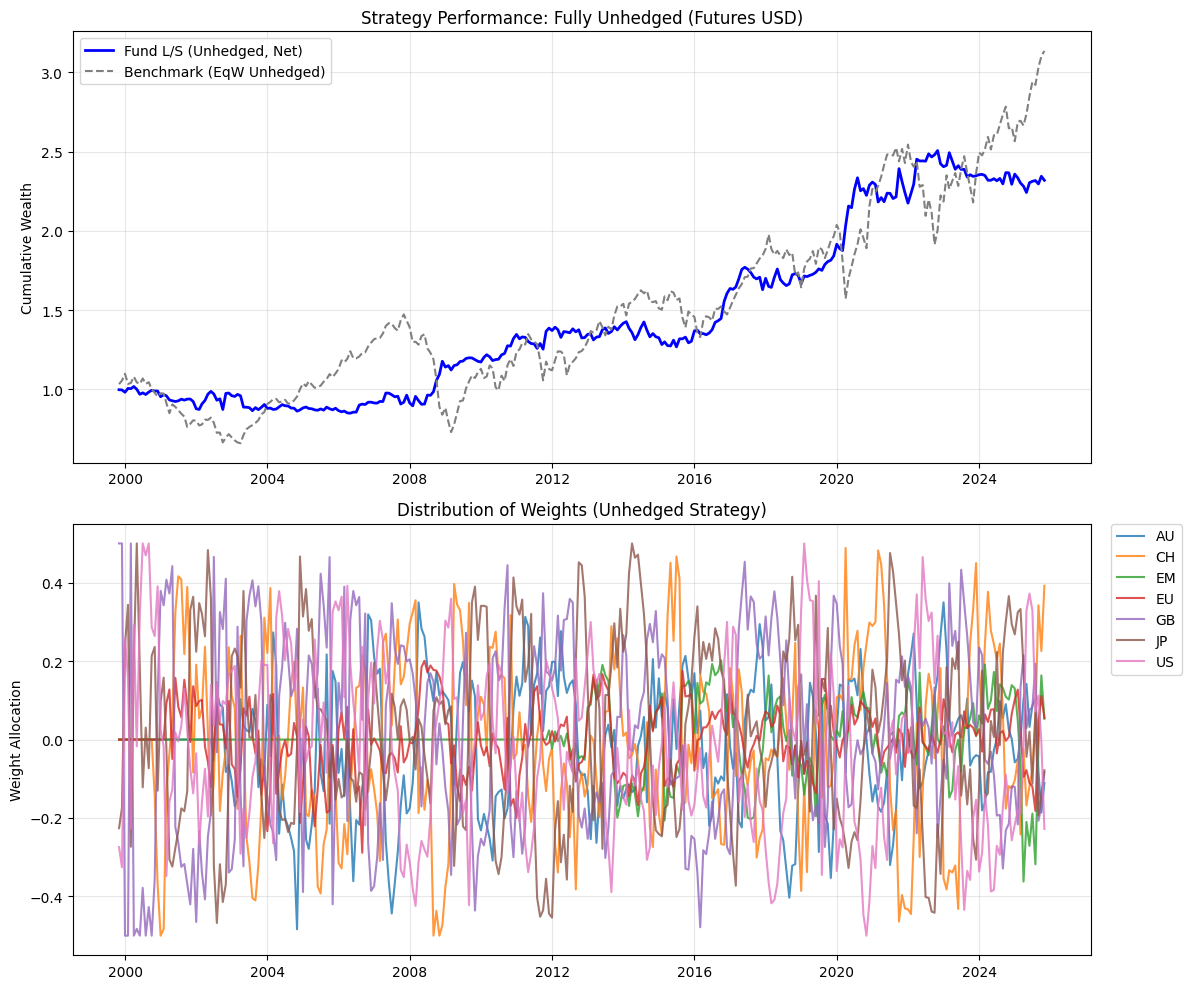

In [7]:
## FUNDAMENTAL STRATEGY 
## --------------------
## This script implements a long/short fundamental strategy across regional equity indices,
## in the spirit of Brooks' macro-momentum approach but using *fundamental indicators*
## (like P/E, P/B, leverage, EPS, ROA, etc.) instead of macro variables.
##
## Core idea:
## 1. Build cross-sectional z-score signals from changes in fundamentals.
## 2. Combine several indicators into one composite signal per region.
## 3. Scale exposures by inverse volatility to target ~10% annual risk.
## 4. Run a long/short portfolio that goes long regions with "good" fundamentals trends
##    and short those with "worsening" fundamentals.
## 5. Compare performance vs equal-weight benchmark.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path
from pandas.tseries.offsets import MonthEnd

# -------------------------------------------------------------------
# 0. CONFIGURATION
# -------------------------------------------------------------------
DATA_DIR = Path(r"C:/Users/Sedláček/Documents/UZH/PMP/Macro_momentum/PMP_December_8/Data")

FUND_FILE  = DATA_DIR / "Fundamental_Indicators.xlsx"
FX_FILE    = DATA_DIR / "FX.xlsx"  # (not used in this version, but kept for consistency)
RF_FILE    = DATA_DIR / "Market_Yield_U.S._T-bill_3-Month_Constant_Maturity.xlsx"
PRICE_FILE = DATA_DIR / "Futures.xlsx"  # Futures in USD used as equity price proxy

# Volatility target for the whole strategy (annualized)
TARGET_VOL_ANN = 0.10

# Transaction cost per unit of *turnover* (e.g. 5 bps per 1 unit traded)
TCOST_PER_UNIT = 0.0005

# Each dict in SIGNAL_CONFIG defines:
# - which fundamental indicator to use
# - the lag (in months) over which to compute "momentum" (change)
# - the sign: +1 if rising indicator is *good*, -1 if rising is *bad*.
SIGNAL_CONFIG = [
    #{"ind": "TOT_DEBT_TO_TOT_EQY", "lag": 6, "sign":  1},  # rising debt interpreted as "good" in your config
    {"ind": "ADJ_PE",              "lag": 6, "sign": -1},  # rising P/E is bad (more expensive)
    {"ind": "PX_TO_BOOK_RATIO",    "lag": 6, "sign": -1},  # rising P/B is bad (more expensive)
    {"ind": "IS_EPS",              "lag": 6, "sign":  1},  # rising EPS is good
    {"ind": "PX_TO_SALES_RATIO",   "lag": 6, "sign": -1},  # rising P/S is bad
    {"ind": "RETURN_ON_ASSET",     "lag": 6, "sign":  1},  # rising ROA is good
]


# =============================================================================
# 1. DATA LOADING FUNCTIONS
# =============================================================================
def load_fundamentals_dict(path: Path) -> dict:
    """
    Load panel of fundamental indicators and return it as a dict of DataFrames.

    Input Excel structure:
        - 'Date' column
        - Other columns like: US_ADJ_PE, US_PX_TO_BOOK_RATIO, JP_ADJ_PE, etc.

    We transform it into:
        fund_dict[indicator_name] = DataFrame (index=Date, columns=Regions)

    Example:
        fund_dict["ADJ_PE"].loc["2010-12-31", "US"] = P/E of US region at that date.
    """
    df = pd.read_excel(path)
    
    # Ensure Date is datetime and aligned to month end
    # (e.g. 2024-01-15 -> 2024-01-31). This matches how returns are stored.
    df["Date"] = pd.to_datetime(df["Date"]) + MonthEnd(0)
    
    # Convert wide columns (US_ADJ_PE, JP_ADJ_PE...) into a long format:
    # Date | raw_col | value
    long = df.melt(id_vars="Date", var_name="raw_col", value_name="value").dropna(subset=["value"])
    
    # Split raw_col into Region & Indicator, e.g. "US_ADJ_PE" -> Region="US", Indicator="ADJ_PE"
    long[["Region", "Indicator"]] = long["raw_col"].str.split("_", n=1, expand=True)
    
    # Pivot into a multi-index columns DataFrame:
    # index  = Date
    # columns = (Indicator, Region)
    # values = value
    full_panel = long.pivot_table(
        index="Date",
        columns=["Indicator", "Region"],
        values="value",
        aggfunc="mean"
    )
    
    # Now split that big panel into a dict by Indicator:
    # For each indicator, we get a DataFrame indexed by Date, columns=Regions.
    fund_dict = {}
    unique_inds = full_panel.columns.get_level_values(0).unique()
    for ind in unique_inds:
        fund_dict[ind] = full_panel[ind].sort_index()
        
    return fund_dict


def load_prices_futures_usd(path: Path) -> pd.DataFrame:
    """
    Load equity futures prices (already in USD) and compute monthly returns.

    Input Excel structure:
        - Date, US, AU, CH, JP, UK, EM, EU

    Steps:
        1. Parse Date.
        2. Rename 'UK' to 'GB' to be consistent with fundamentals.
        3. Set Date as index and sort.
        4. Compute simple percentage returns per month.
        5. Shift index to month-end (for alignment with fundamentals & RF).
        6. If duplicates arise after shifting, take last value per month.

    Output:
        ret_panel: DataFrame of returns, index=month-end, columns=regions.
    """
    df = pd.read_excel(path)
    df["Date"] = pd.to_datetime(df["Date"])
    
    # Ensure UK is mapped to GB to match region naming in fundamentals.
    if "UK" in df.columns:
        df = df.rename(columns={"UK": "GB"})

    df = df.set_index("Date").sort_index()
    
    # Monthly returns in USD (because futures are quoted in USD already)
    ret_panel = df.pct_change()
    
    # Align index to month end: 1997-09-30 stays end of month, but any odd date gets pushed to MonthEnd.
    ret_panel.index = ret_panel.index + MonthEnd(0)
    
    # If multiple entries fall into the same month-end after shifting,
    # keep the last one (common when data has multiple days).
    ret_panel = ret_panel.groupby(level=0).last()
    
    return ret_panel


def load_rf(path: Path) -> pd.Series:
    """
    Load risk-free rate (here: 3M US T-bill) as a monthly series.

    Expects sheet 'Monthly' with:
        - 'observation_date' column (date)
        - 'Return' column (already in monthly return units, e.g. 0.002)
    """
    df = pd.read_excel(path, sheet_name="Monthly")
    df["Date"] = pd.to_datetime(df["observation_date"]) + MonthEnd(0)
    df = df.set_index("Date").sort_index()
    return df["Return"]


# =============================================================================
# 2. CALCULATION LOGIC (SIGNALS)
# =============================================================================
def compute_signals(fund_dict, returns_df, config):
    """
    Construct the composite fundamental signal and estimate rolling volatility.

    Inputs:
        fund_dict  : dict of DataFrames, one per indicator: fund_dict[ind]
                     Each DataFrame: index=Date, columns=Regions
        returns_df : DataFrame of USD returns (futures), index=Date, columns=Regions
        config     : SIGNAL_CONFIG list, specifying which indicators to use,
                     their lags, and sign.

    Outputs:
        rolling_std : DataFrame of rolling volatilities (per region, per date)
        final_signal: DataFrame of composite z-score signals (per region, per date)

    Logic:
        - rolling_std is used to scale positions by 1/vol (risk parity style).
        - final_signal is a cross-sectional z-score of fundamental "momentum"
          (differences over 'lag' months, signed by economic interpretation).
    """

    # 1) Estimate rolling vol per region using historical returns
    #    We use 36-month window, require at least 24 observations.
    rolling_std = (
        returns_df
        .rolling(window=36, min_periods=24)
        .std()
        .replace(0, np.nan)
    )
    
    # 2) master_z will accumulate z-scores across different indicators
    master_z = pd.DataFrame(0.0, index=returns_df.index, columns=returns_df.columns)
    valid_count = 0  # how many indicators were actually found & used
    
    # 3) Loop over each configured indicator
    for cfg in config:
        ind  = cfg["ind"]
        lag  = cfg["lag"]
        sign = cfg["sign"]  # +1 or -1 depending on whether higher is "good" or "bad"
        
        if ind in fund_dict:
            panel = fund_dict[ind]   # DataFrame: dates x regions

            # "Momentum" of fundamentals = change over 'lag' months, times sign.
            # Example: mom_t = sign * (fund_t - fund_t-lag)
            mom = panel.diff(lag) * sign

            # Cross-sectional mean & std across regions at each date
            mu    = mom.mean(axis=1)
            sigma = mom.std(axis=1)

            # Cross-sectional z-score: (mom - mean) / std
            # This makes signals comparable across indicators & time.
            z = mom.sub(mu, axis=0).div(sigma, axis=0).fillna(0)

            # Add z-scores to master composite signal
            master_z = master_z.add(z, fill_value=0)

            valid_count += 1
            
    # Average across indicators to form the final signal
    final_signal = master_z / valid_count if valid_count > 0 else master_z

    return rolling_std, final_signal


# =============================================================================
# 3. BACKTEST ENGINE & PERFORMANCE SUMMARY
# =============================================================================
def run_cc_strategy(weights, returns, rf, frequency=1, t_cost=0.0,
                    benchmark="equal", long_short=False, beta_neutral=False):
    """
    Generic portfolio backtest engine (cross-country strategy).

    Inputs:
        weights   : DataFrame of target weights per date & region (strategic signal).
        returns   : DataFrame of asset returns per date & region (here: total USD returns).
        rf        : Series of risk-free returns per date (monthly).
        frequency : rebalance frequency in months (1 = monthly, 3 = quarterly, ...).
        t_cost    : transaction cost per unit of turnover (e.g. 0.0005 = 5 bps).
        benchmark : "equal" for equal-weight benchmark, else 0 benchmark.
        long_short: if True, re-normalize post-return weights to be long/short and dollar-neutral.
        beta_neutral: (not used here, placeholder for potential beta-neutral logic).

    Output:
        DataFrame indexed by Date with:
            ret_net   : net portfolio return (after t_cost)
            ret_gross : gross portfolio return (before t_cost)
            ret_bm    : benchmark return
            ret_rf    : risk-free rate
            turnover  : dollar turnover fraction
            tcost     : total transaction cost
            w_<REG>   : end-of-period weights per region
    """

    # Align weights, returns, rf on the same date index and region columns
    weights = weights.copy().fillna(0)
    returns = returns.reindex(weights.index).copy()
    returns = returns[weights.columns]
    rf = rf.reindex(weights.index).fillna(0)
    
    dates   = list(weights.index)
    regions = list(weights.columns)
    
    # Rebalance schedule: 1 on rebalance dates, 0 otherwise
    rebalance = pd.Series(0, index=dates, dtype=int)
    rebalance.iloc[::frequency] = 1  # every 'frequency' months
    rebalance.iloc[0] = 1           # ensure first date has a rebalance

    # Setup benchmark: by default equal-weight across all regions
    if benchmark == "equal":
        benchmark_w = pd.DataFrame(1.0/len(regions), index=weights.index, columns=regions)
        bm_returns = (benchmark_w * returns).sum(axis=1)
    else:
        # if no benchmark, treat benchmark return as 0
        bm_returns = pd.Series(0, index=weights.index)

    # Start from initial weights = first row of the weights DataFrame
    current_weight = weights.iloc[0].copy()
    results = []

    # Loop through time, using weights at date t to trade into returns at t+1
    for i in range(len(dates) - 1):
        date      = dates[i]
        next_date = dates[i + 1]

        # 1. If this is a rebalance date, adjust from current to target weights.
        if rebalance.loc[date] == 1:
            target_weight = weights.loc[date].fillna(0)
            
            # Turnover = 0.5 * sum(|w_new - w_old|) across all assets
            # 0.5 factor because buying & selling both sides.
            turnover = 0.5 * (target_weight - current_weight).abs().sum()
            
            # Update current portfolio weights
            current_weight = target_weight.copy()
        else:
            turnover = 0.0

        # 2. Apply next month's returns to current weights
        r_vec = returns.loc[next_date].fillna(0.0)  # asset returns for next_date
        
        # Gross portfolio return = sum(w * r)
        gross_ret = (current_weight * r_vec).sum()
        
        # Transaction cost = turnover * t_cost
        tcost_val = turnover * t_cost
        
        # Net return = gross return minus transaction cost
        net_ret = gross_ret - tcost_val
        
        # Benchmark return at next_date
        bm_ret = bm_returns.loc[next_date]

        # 3. Let positions drift with returns (before any rebalancing at next loop)
        new_weight = current_weight * (1 + r_vec)
        
        # 4. If long_short=True, normalize to a long/short, dollar-neutral portfolio
        if long_short:
            # Consider only assets with non-zero current exposure
            active = current_weight[current_weight != 0].index
            if len(active) > 0:
                new_active = current_weight[active] * (1 + r_vec[active])
                
                # Center weights to make them sum to zero: w_i - mean(w)
                centered = new_active - new_active.mean()
                
                # Normalize sum(|w_i|) = 1 for these active names
                denom = centered.abs().sum()
                if denom > 0:
                    centered = centered / denom
                
                # Store back into full vector (others = 0)
                current_weight = pd.Series(0.0, index=current_weight.index)
                current_weight[active] = centered
            else:
                # If no active positions, just carry forward new_weight
                current_weight = new_weight.copy()
        else:
            # If not long_short, just keep the drifted weights
            current_weight = new_weight.copy()

        # 5. Collect results for this period
        row = {
            "Date": next_date,
            "ret_net":   net_ret,
            "ret_gross": gross_ret,
            "ret_bm":    bm_ret,
            "turnover":  turnover,
            "tcost":     tcost_val,
            "ret_rf":    rf.loc[next_date] if next_date in rf.index else 0.0
        }
        for reg in regions:
            row[f"w_{reg}"] = current_weight.get(reg, 0.0)
            
        results.append(row)

    # Build results DataFrame with Date as index
    return pd.DataFrame(results).set_index("Date")


def summarizePerformance(xsReturns, Rf, factorXsReturns, annualizationFactor=12, strategyNames=None):
    """
    Compute performance stats for one or more strategies:
        - Annualized excess return
        - Annualized volatility
        - Sharpe ratio
        - Beta vs benchmark factor
        - Annualized alpha
        - Correlation with benchmark factor

    xsReturns       : 2D numpy array (T x N) of excess returns for N strategies
    Rf              : 2D numpy array (T x 1) of risk-free rates (not heavily used here)
    factorXsReturns : 1D or 2D array of factor (benchmark) excess returns
    """
    # Convert to numpy arrays (ensure shapes consistent)
    xsReturns       = np.array(xsReturns)
    factorXsReturns = np.array(factorXsReturns).flatten()
    
    metrics = []
    
    for i in range(xsReturns.shape[1]):
        r_xs = xsReturns[:, i]  # time series of excess returns for strategy i
        
        # Basic statistics
        mu = np.mean(r_xs) * annualizationFactor                    # annualized mean
        sig = np.std(r_xs, ddof=1) * np.sqrt(annualizationFactor)   # annualized vol
        sharpe = mu / sig if sig > 0 else 0
        
        # Regression vs benchmark factor to get beta, alpha, correlation
        if np.std(factorXsReturns) == 0 or np.std(r_xs) == 0:
            beta, alpha, corr = 0.0, 0.0, 0.0
        else:
            slope, intercept, r_value, _, _ = stats.linregress(factorXsReturns, r_xs)
            beta  = slope
            alpha = intercept * annualizationFactor  # annualize alpha
            corr  = r_value
            
        metrics.append({
            "Ann. Return (XS)": mu,
            "Ann. Volatility":  sig,
            "Sharpe Ratio":     sharpe,
            "Beta":             beta,
            "Ann. Alpha":       alpha,
            "Correlation":      corr
        })
        
    df = pd.DataFrame(
        metrics,
        index=strategyNames if strategyNames else [f"Strat {i}" for i in range(len(metrics))]
    )
    return df.T


def run_perf_summary_benchmark_vs_strategy(
    results,
    alreadyXs=False,
    annualizationFactor=12,
    strategyNames=["Benchmark", "Strategy"]
):
    """
    Wrapper to compute performance summary for:
        - Benchmark excess return
        - Strategy excess return

    Inputs:
        results     : DataFrame returned by run_cc_strategy
        alreadyXs   : if True, ret_net is already excess return; if False, subtract rf
        annualizationFactor : 12 for monthly data
        strategyNames: labels for [Benchmark, Strategy]
    """

    # 1) Benchmark excess return (benchmark net of RF)
    xs_bm = results["ret_bm"] - results["ret_rf"]

    # 2) Strategy excess return
    if alreadyXs:
        xs_str = results["ret_net"]
    else:
        xs_str = results["ret_net"] - results["ret_rf"]

    # 3) Combine into matrix: columns = [benchmark, strategy]
    xsReturns = np.column_stack([xs_bm, xs_str])

    # 4) Risk-free as 2D matrix T x 1
    Rf = results["ret_rf"].to_numpy().reshape(-1, 1)

    # 5) Factor XS returns = benchmark XS returns (again T x 1)
    factorXsReturns = (results["ret_bm"].to_numpy() - 
                       results["ret_rf"].to_numpy()).reshape(-1, 1)

    # 6) Call the summarizer
    return summarizePerformance(
        xsReturns=xsReturns,
        Rf=Rf,
        factorXsReturns=factorXsReturns,
        annualizationFactor=annualizationFactor,
        strategyNames=strategyNames
    )


# =============================================================================
# 4. MAIN EXECUTION (FULLY UNHEDGED - FUTURES)
# =============================================================================

# A. Load Data
print("Loading Data...")
fund_dict  = load_fundamentals_dict(FUND_FILE)   # dict of indicator panels
rf_series  = load_rf(RF_FILE)                    # monthly risk-free rate (US T-bill)
ret_unhedged_usd = load_prices_futures_usd(PRICE_FILE)  # USD equity returns from futures

# B. Calculate Signals
#    - vol_usd: per-region rolling volatility (used for risk scaling)
#    - signal : composite fundamental z-score signal (per region, per month)
vol_usd, signal = compute_signals(fund_dict, ret_unhedged_usd, SIGNAL_CONFIG)

# C. Calculate Weights
#    - Convert annual target vol to monthly target vol:
vol_target_monthly = TARGET_VOL_ANN / np.sqrt(12)

#    - risk_scaler ~ (target_vol / realized_vol)
#      If a region is more volatile, its weight gets scaled down.
risk_scaler = vol_target_monthly / vol_usd

#    - raw_weights = signal * risk_scaler
#      This is a risk-parity-like weighting: stronger signal & lower vol → larger position.
raw_weights = signal * risk_scaler

# D. Prepare Data for Backtest Engine
#    - Align weights to return index (should already match, but reindex to be safe)
final_weights = raw_weights.reindex(ret_unhedged_usd.index).fillna(0)

print("Running Backtest (Unhedged Futures)...")
perf_df = run_cc_strategy(
    weights      = final_weights,
    returns      = ret_unhedged_usd.dropna(how='all'), # total USD returns
    rf           = rf_series,
    t_cost       = TCOST_PER_UNIT,
    benchmark    = "equal",   # equal-weight benchmark
    long_short   = True,      # normalize to long/short, dollar-neutral
    beta_neutral = False      # not implemented, placeholder
)

# E. Plotting & Summary
#    Filter out initial periods before the first actual rebalance (zero turnover cumulative)
perf_df = perf_df[perf_df["turnover"].cumsum() > 0]

# Build cumulative wealth curves
cum_strat = (1 + perf_df["ret_net"]).cumprod()
cum_bench = (1 + perf_df["ret_bm"]).cumprod()

print("\n--- PERFORMANCE SUMMARY (UNHEDGED) ---")
summary_table = run_perf_summary_benchmark_vs_strategy(
    results=perf_df,
    alreadyXs=False,  # ret_net is total return; function subtracts RF
    annualizationFactor=12,
    strategyNames=["Benchmark (EqW)", "Fund L/S (Unhedged)"]
)
print(summary_table)

# --- DETAILED MONTHLY RETURNS & WEIGHTS ---
print("\n--- DETAILED MONTHLY RETURNS & WEIGHTS ---")
cols_to_show = ["ret_net", "ret_gross", "ret_rf", "ret_bm"] + [
    c for c in perf_df.columns if c.startswith("w_")
]

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(perf_df[cols_to_show])

# --------------------------------------------------
# Plot performance & weights
plt.figure(figsize=(12, 10))

# Plot 1: Cumulative wealth (strategy vs benchmark)
plt.subplot(2, 1, 1)
plt.plot(cum_strat.index, cum_strat, label="Fund L/S (Unhedged, Net)", color='blue', linewidth=2)
plt.plot(cum_bench.index, cum_bench, label="Benchmark (EqW Unhedged)", color='gray', linestyle="--")
plt.title("Strategy Performance: Fully Unhedged (Futures USD)")
plt.ylabel("Cumulative Wealth")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Time series of region weights
plt.subplot(2, 1, 2)
w_cols = [c for c in perf_df.columns if c.startswith("w_")]
weights_plot = perf_df[w_cols].copy()
weights_plot.columns = [c.replace("w_", "") for c in weights_plot.columns]

for col in weights_plot.columns:
    plt.plot(weights_plot.index, weights_plot[col], label=col, linewidth=1.5, alpha=0.8)

plt.title("Distribution of Weights (Unhedged Strategy)")
plt.ylabel("Weight Allocation")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path
from pandas.tseries.offsets import MonthEnd
from pmp_functions_v4 import (
    run_perf_summary_benchmark_vs_strategy,
    run_cc_strategy,
) 

Loading Data...
Running Backtest (Unhedged Futures)...

--- PERFORMANCE SUMMARY (UNHEDGED) ---
                         Benchmark (EqW)  Fund L/S (Unhedged)
Arithm Avg Total Return           5.4727               3.5665
Arithm Avg Xs Return              3.5121               1.6059
Std Xs Returns                   14.6897               8.7786
Sharpe Arithmetic                 0.2391               0.1829
Geom Avg Total Return             4.4770               3.2414
Geom Avg Xs Return                2.5003               1.2647
Sharpe Geometric                  0.1702               0.1441
Min Xs Return                   -16.4533              -7.5228
Max Xs Return                    14.0031              11.5026
Skewness                         -0.4154               0.7679
Excess Kurtosis                   1.0546               2.2493
Alpha Arithmetic                  0.0000               1.5923
Alpha Arithmetic p-val            0.0000               0.3514
Alpha Geometric                   0.0

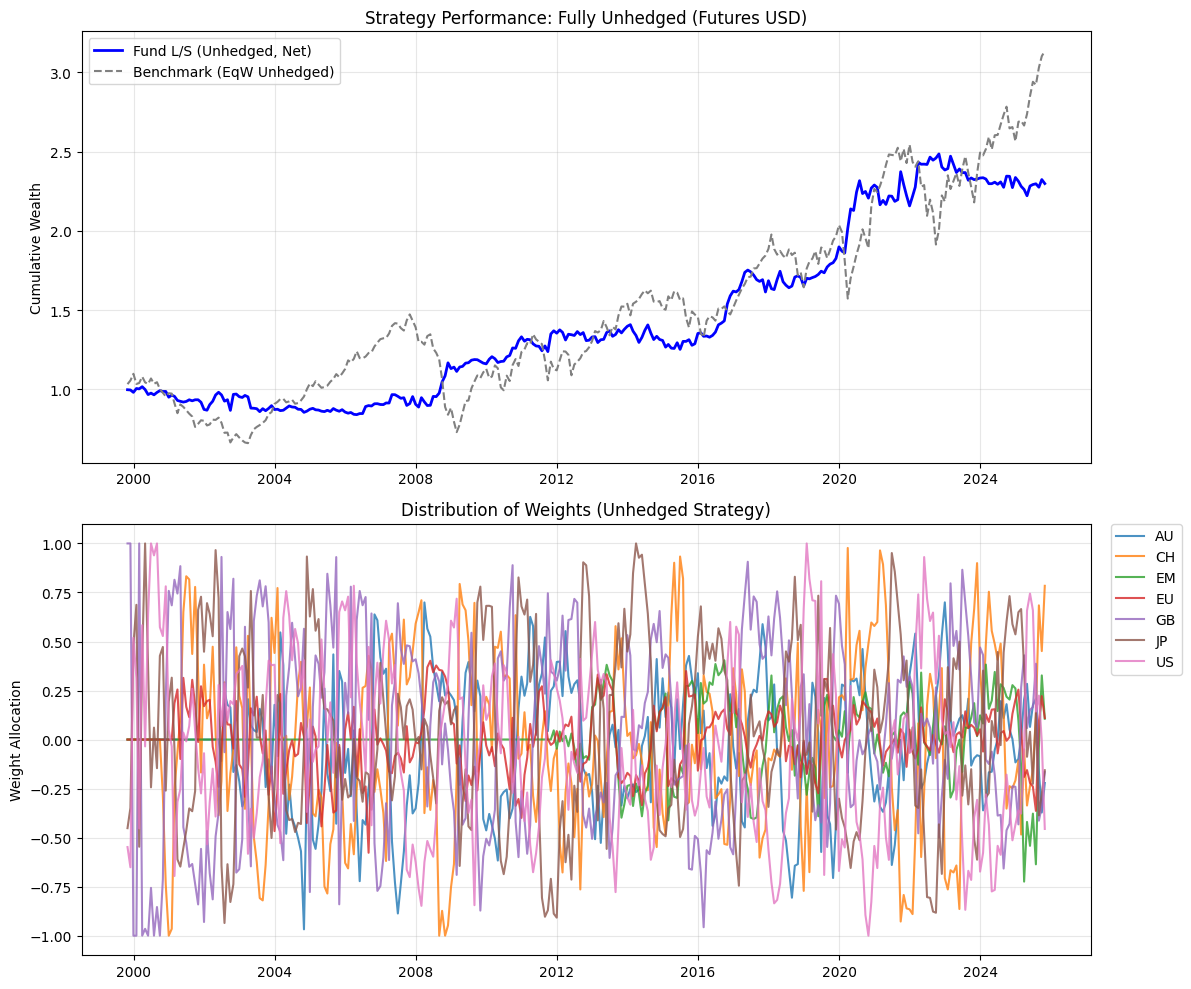

In [2]:
## FUNDAMENTAL STRATEGY 
## --------------------
## This script implements a long/short fundamental strategy across regional equity indices,
## in the spirit of Brooks' macro-momentum approach but using *fundamental indicators*
## (like P/E, P/B, leverage, EPS, ROA, etc.) instead of macro variables.
##
## Core idea:
## 1. Build cross-sectional z-score signals from changes in fundamentals.
## 2. Combine several indicators into one composite signal per region.
## 3. Scale exposures by inverse volatility to target ~10% annual risk.
## 4. Run a long/short portfolio that goes long regions with "good" fundamentals trends
##    and short those with "worsening" fundamentals.
## 5. Compare performance vs equal-weight benchmark.



# -------------------------------------------------------------------
# 0. CONFIGURATION
# -------------------------------------------------------------------
DATA_DIR = Path(r"C:/Users/Sedláček/Documents/UZH/PMP/Macro_momentum/PMP_December_8/Data")

FUND_FILE  = DATA_DIR / "Fundamental_Indicators.xlsx"
FX_FILE    = DATA_DIR / "FX.xlsx"  # (not used in this version, but kept for consistency)
RF_FILE    = DATA_DIR / "Market_Yield_U.S._T-bill_3-Month_Constant_Maturity.xlsx"
PRICE_FILE = DATA_DIR / "Futures.xlsx"  # Futures in USD used as equity price proxy

# Volatility target for the whole strategy (annualized)
TARGET_VOL_ANN = 0.10

# Transaction cost per unit of *turnover* (e.g. 5 bps per 1 unit traded)
TCOST_PER_UNIT = 0.0005

# Each dict in SIGNAL_CONFIG defines:
# - which fundamental indicator to use
# - the lag (in months) over which to compute "momentum" (change)
# - the sign: +1 if rising indicator is *good*, -1 if rising is *bad*.
SIGNAL_CONFIG = [
    #{"ind": "TOT_DEBT_TO_TOT_EQY", "lag": 6, "sign":  1},  # rising debt interpreted as "good" in your config
    {"ind": "ADJ_PE",              "lag": 6, "sign": -1},  # rising P/E is bad (more expensive)
    {"ind": "PX_TO_BOOK_RATIO",    "lag": 6, "sign": -1},  # rising P/B is bad (more expensive)
    {"ind": "IS_EPS",              "lag": 6, "sign":  1},  # rising EPS is good
    {"ind": "PX_TO_SALES_RATIO",   "lag": 6, "sign": -1},  # rising P/S is bad
    {"ind": "RETURN_ON_ASSET",     "lag": 6, "sign":  1},  # rising ROA is good
]


# =============================================================================
# 1. DATA LOADING FUNCTIONS
# =============================================================================
def load_fundamentals_dict(path: Path) -> dict:
    """
    Load panel of fundamental indicators and return it as a dict of DataFrames.

    Input Excel structure:
        - 'Date' column
        - Other columns like: US_ADJ_PE, US_PX_TO_BOOK_RATIO, JP_ADJ_PE, etc.

    We transform it into:
        fund_dict[indicator_name] = DataFrame (index=Date, columns=Regions)

    Example:
        fund_dict["ADJ_PE"].loc["2010-12-31", "US"] = P/E of US region at that date.
    """
    df = pd.read_excel(path)
    
    # Ensure Date is datetime and aligned to month end
    # (e.g. 2024-01-15 -> 2024-01-31). This matches how returns are stored.
    df["Date"] = pd.to_datetime(df["Date"]) + MonthEnd(0)
    
    # Convert wide columns (US_ADJ_PE, JP_ADJ_PE...) into a long format:
    # Date | raw_col | value
    long = df.melt(id_vars="Date", var_name="raw_col", value_name="value").dropna(subset=["value"])
    
    # Split raw_col into Region & Indicator, e.g. "US_ADJ_PE" -> Region="US", Indicator="ADJ_PE"
    long[["Region", "Indicator"]] = long["raw_col"].str.split("_", n=1, expand=True)
    
    # Pivot into a multi-index columns DataFrame:
    # index  = Date
    # columns = (Indicator, Region)
    # values = value
    full_panel = long.pivot_table(
        index="Date",
        columns=["Indicator", "Region"],
        values="value",
        aggfunc="mean"
    )
    
    # Now split that big panel into a dict by Indicator:
    # For each indicator, we get a DataFrame indexed by Date, columns=Regions.
    fund_dict = {}
    unique_inds = full_panel.columns.get_level_values(0).unique()
    for ind in unique_inds:
        fund_dict[ind] = full_panel[ind].sort_index()
        
    return fund_dict


def load_prices_futures_usd(path: Path) -> pd.DataFrame:
    """
    Load equity futures prices (already in USD) and compute monthly returns.

    Input Excel structure:
        - Date, US, AU, CH, JP, UK, EM, EU

    Steps:
        1. Parse Date.
        2. Rename 'UK' to 'GB' to be consistent with fundamentals.
        3. Set Date as index and sort.
        4. Compute simple percentage returns per month.
        5. Shift index to month-end (for alignment with fundamentals & RF).
        6. If duplicates arise after shifting, take last value per month.

    Output:
        ret_panel: DataFrame of returns, index=month-end, columns=regions.
    """
    df = pd.read_excel(path)
    df["Date"] = pd.to_datetime(df["Date"])
    
    # Ensure UK is mapped to GB to match region naming in fundamentals.
    if "UK" in df.columns:
        df = df.rename(columns={"UK": "GB"})

    df = df.set_index("Date").sort_index()
    
    # Monthly returns in USD (because futures are quoted in USD already)
    ret_panel = df.pct_change()
    
    # Align index to month end: 1997-09-30 stays end of month, but any odd date gets pushed to MonthEnd.
    ret_panel.index = ret_panel.index + MonthEnd(0)
    
    # If multiple entries fall into the same month-end after shifting,
    # keep the last one (common when data has multiple days).
    ret_panel = ret_panel.groupby(level=0).last()
    
    return ret_panel


def load_rf(path: Path) -> pd.Series:
    """
    Load risk-free rate (here: 3M US T-bill) as a monthly series.

    Expects sheet 'Monthly' with:
        - 'observation_date' column (date)
        - 'Return' column (already in monthly return units, e.g. 0.002)
    """
    df = pd.read_excel(path, sheet_name="Monthly")
    df["Date"] = pd.to_datetime(df["observation_date"]) + MonthEnd(0)
    df = df.set_index("Date").sort_index()
    return df["Return"]


# =============================================================================
# 2. CALCULATION LOGIC (SIGNALS)
# =============================================================================
def compute_signals(fund_dict, returns_df, config):
    """
    Construct the composite fundamental signal and estimate rolling volatility.

    Inputs:
        fund_dict  : dict of DataFrames, one per indicator: fund_dict[ind]
                     Each DataFrame: index=Date, columns=Regions
        returns_df : DataFrame of USD returns (futures), index=Date, columns=Regions
        config     : SIGNAL_CONFIG list, specifying which indicators to use,
                     their lags, and sign.

    Outputs:
        rolling_std : DataFrame of rolling volatilities (per region, per date)
        final_signal: DataFrame of composite z-score signals (per region, per date)

    Logic:
        - rolling_std is used to scale positions by 1/vol (risk parity style).
        - final_signal is a cross-sectional z-score of fundamental "momentum"
          (differences over 'lag' months, signed by economic interpretation).
    """

    # 1) Estimate rolling vol per region using historical returns
    #    We use 36-month window, require at least 24 observations.
    rolling_std = (
        returns_df
        .rolling(window=36, min_periods=24)
        .std()
        .replace(0, np.nan)
    )
    
    # 2) master_z will accumulate z-scores across different indicators
    master_z = pd.DataFrame(0.0, index=returns_df.index, columns=returns_df.columns)
    valid_count = 0  # how many indicators were actually found & used
    
    # 3) Loop over each configured indicator
    for cfg in config:
        ind  = cfg["ind"]
        lag  = cfg["lag"]
        sign = cfg["sign"]  # +1 or -1 depending on whether higher is "good" or "bad"
        
        if ind in fund_dict:
            panel = fund_dict[ind]   # DataFrame: dates x regions

            # "Momentum" of fundamentals = change over 'lag' months, times sign.
            # Example: mom_t = sign * (fund_t - fund_t-lag)
            mom = panel.diff(lag) * sign

            # Cross-sectional mean & std across regions at each date
            mu    = mom.mean(axis=1)
            sigma = mom.std(axis=1)

            # Cross-sectional z-score: (mom - mean) / std
            # This makes signals comparable across indicators & time.
            z = mom.sub(mu, axis=0).div(sigma, axis=0).fillna(0)

            # Add z-scores to master composite signal
            master_z = master_z.add(z, fill_value=0)

            valid_count += 1
            
    # Average across indicators to form the final signal
    final_signal = master_z / valid_count if valid_count > 0 else master_z

    return rolling_std, final_signal


# =============================================================================
# 3. BACKTEST ENGINE & PERFORMANCE SUMMARY
# =============================================================================



def summarizePerformance(xsReturns, Rf, factorXsReturns, annualizationFactor=12, strategyNames=None):
    """
    Compute performance stats for one or more strategies:
        - Annualized excess return
        - Annualized volatility
        - Sharpe ratio
        - Beta vs benchmark factor
        - Annualized alpha
        - Correlation with benchmark factor

    xsReturns       : 2D numpy array (T x N) of excess returns for N strategies
    Rf              : 2D numpy array (T x 1) of risk-free rates (not heavily used here)
    factorXsReturns : 1D or 2D array of factor (benchmark) excess returns
    """
    # Convert to numpy arrays (ensure shapes consistent)
    xsReturns       = np.array(xsReturns)
    factorXsReturns = np.array(factorXsReturns).flatten()
    
    metrics = []
    
    for i in range(xsReturns.shape[1]):
        r_xs = xsReturns[:, i]  # time series of excess returns for strategy i
        
        # Basic statistics
        mu = np.mean(r_xs) * annualizationFactor                    # annualized mean
        sig = np.std(r_xs, ddof=1) * np.sqrt(annualizationFactor)   # annualized vol
        sharpe = mu / sig if sig > 0 else 0
        
        # Regression vs benchmark factor to get beta, alpha, correlation
        if np.std(factorXsReturns) == 0 or np.std(r_xs) == 0:
            beta, alpha, corr = 0.0, 0.0, 0.0
        else:
            slope, intercept, r_value, _, _ = stats.linregress(factorXsReturns, r_xs)
            beta  = slope
            alpha = intercept * annualizationFactor  # annualize alpha
            corr  = r_value
            
        metrics.append({
            "Ann. Return (XS)": mu,
            "Ann. Volatility":  sig,
            "Sharpe Ratio":     sharpe,
            "Beta":             beta,
            "Ann. Alpha":       alpha,
            "Correlation":      corr
        })
        
    df = pd.DataFrame(
        metrics,
        index=strategyNames if strategyNames else [f"Strat {i}" for i in range(len(metrics))]
    )
    return df.T




# =============================================================================
# 4. MAIN EXECUTION (FULLY UNHEDGED - FUTURES)
# =============================================================================

# A. Load Data
print("Loading Data...")
fund_dict  = load_fundamentals_dict(FUND_FILE)   # dict of indicator panels
rf_series  = load_rf(RF_FILE)                    # monthly risk-free rate (US T-bill)
ret_unhedged_usd = load_prices_futures_usd(PRICE_FILE)  # USD equity returns from futures

# B. Calculate Signals
#    - vol_usd: per-region rolling volatility (used for risk scaling)
#    - signal : composite fundamental z-score signal (per region, per month)
vol_usd, signal = compute_signals(fund_dict, ret_unhedged_usd, SIGNAL_CONFIG)

# C. Calculate Weights
#    - Convert annual target vol to monthly target vol:
vol_target_monthly = TARGET_VOL_ANN / np.sqrt(12)

#    - risk_scaler ~ (target_vol / realized_vol)
#      If a region is more volatile, its weight gets scaled down.
risk_scaler = vol_target_monthly / vol_usd

#    - raw_weights = signal * risk_scaler
#      This is a risk-parity-like weighting: stronger signal & lower vol → larger position.
raw_weights = signal * risk_scaler

# D. Prepare Data for Backtest Engine
#    - Align weights to return index (should already match, but reindex to be safe)
final_weights = raw_weights.reindex(ret_unhedged_usd.index).fillna(0)

print("Running Backtest (Unhedged Futures)...")
perf_df = run_cc_strategy(
    weights      = final_weights,
    returns      = ret_unhedged_usd.dropna(how='all'), # total USD returns
    rf           = rf_series,
    t_cost       = TCOST_PER_UNIT,
    benchmark    = "equal",   # equal-weight benchmark
    long_short   = True,      # normalize to long/short, dollar-neutral
    beta_neutral = False      # not implemented, placeholder
)

# E. Plotting & Summary
#    Filter out initial periods before the first actual rebalance (zero turnover cumulative)
perf_df = perf_df[perf_df["turnover"].cumsum() > 0]

# Build cumulative wealth curves
cum_strat = (1 + perf_df["ret_net"]).cumprod()
cum_bench = (1 + perf_df["ret_bm"]).cumprod()

print("\n--- PERFORMANCE SUMMARY (UNHEDGED) ---")
summary_table = run_perf_summary_benchmark_vs_strategy(
    results=perf_df,
    alreadyXs=False,  # ret_net is total return; function subtracts RF
    annualizationFactor=12,
    strategyNames=["Benchmark (EqW)", "Fund L/S (Unhedged)"]
)
print(summary_table)

# --- DETAILED MONTHLY RETURNS & WEIGHTS ---
print("\n--- DETAILED MONTHLY RETURNS & WEIGHTS ---")
cols_to_show = ["ret_net", "ret_gross", "ret_rf", "ret_bm"] + [
    c for c in perf_df.columns if c.startswith("w_")
]

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(perf_df[cols_to_show])

# --------------------------------------------------
# Plot performance & weights
plt.figure(figsize=(12, 10))

# Plot 1: Cumulative wealth (strategy vs benchmark)
plt.subplot(2, 1, 1)
plt.plot(cum_strat.index, cum_strat, label="Fund L/S (Unhedged, Net)", color='blue', linewidth=2)
plt.plot(cum_bench.index, cum_bench, label="Benchmark (EqW Unhedged)", color='gray', linestyle="--")
plt.title("Strategy Performance: Fully Unhedged (Futures USD)")
plt.ylabel("Cumulative Wealth")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Time series of region weights
plt.subplot(2, 1, 2)
w_cols = [c for c in perf_df.columns if c.startswith("w_")]
weights_plot = perf_df[w_cols].copy()
weights_plot.columns = [c.replace("w_", "") for c in weights_plot.columns]

for col in weights_plot.columns:
    plt.plot(weights_plot.index, weights_plot[col], label=col, linewidth=1.5, alpha=0.8)

plt.title("Distribution of Weights (Unhedged Strategy)")
plt.ylabel("Weight Allocation")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()